<a href="https://colab.research.google.com/github/sasaigoli05/BIOL105-CompBioModule/blob/main/HBB_11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
jobname = 'test'
# number of models to use
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname test_a5e17
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer biopython") # Added biopython here
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}' biopython") # Added biopython here
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer biopython") # Added biopython here
    os.system("touch AMBER_READY")


# Define the hydrophobic core based on the position of "GRLLVVYPWT" in the original hemoglobin sequence
hydrophobic_core_sequence = "GRLLVVYPWT"
original_sequence = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"

# Find positions of the hydrophobic core in the original sequence
core_start_index = original_sequence.find(hydrophobic_core_sequence) + 1
core_positions = list(range(core_start_index, core_start_index + len(hydrophobic_core_sequence)))

# Add "hydrophobic_core" to the residue_categories dictionary
residue_categories = {
    'BPG_binding': [2, 3, 83, 144],
    'iron_binding': [64, 93],
    'not_glycated': [60, 83, 96],
    'cleavage_sites': [8, 9, 26, 27, 30, 31, 36, 37, 38, 39, 46, 47, 53, 54, 57, 58, 60, 72, 73, 75, 76, 85, 86, 93, 94, 105, 106, 111, 112, 120, 121, 123, 124, 129, 130, 141, 142, 145, 146],
    'hydrophobic_core': core_positions  # Positions of the "hydrophobic core"
}

# Define dictionary for residue charges
residue_charge = {
    'K': 'positive',  # Lysine
    'R': 'positive',  # Arginine
    'H': 'positive',  # Histidine (partially positive at physiological pH)
    'D': 'negative',  # Aspartic acid
    'E': 'negative',  # Glutamic acid
    'A': 'neutral',  # Alanine
    'G': 'neutral',  # Glycine
    'V': 'neutral',  # Valine
    'L': 'neutral',  # Leucine
    'I': 'neutral',  # Isoleucine
    'P': 'neutral',  # Proline
    'F': 'neutral',  # Phenylalanine
    'M': 'neutral',  # Methionine
    'W': 'neutral',  # Tryptophan
    'S': 'neutral',  # Serine
    'T': 'neutral',  # Threonine
    'C': 'neutral',  # Cysteine (neutral, though can form disulfide bonds)
    'N': 'neutral',  # Asparagine
    'Q': 'neutral',  # Glutamine
    'Y': 'neutral'   # Tyrosine (polar, but neutral at physiological pH)
}

# Function to query residues based on category
def query_residues_by_category(sequence, category):
    """Query residues in sequence by category and determine charge type."""
    result = []
    for pos in residue_categories[category]:
        if pos <= len(sequence):
            residue = sequence[pos - 1]  # Adjust for 0-based index
            charge = residue_charge.get(residue, 'unknown')
            result.append(f"Position {pos}: {residue} ({charge})")
    return result

# Updated function to print residues by category
def print_residues_by_category(category):
    """Prints residues and their charges based on the selected category."""
    residues_info = query_residues_by_category(mutant_sequence, category)
    print(f"Residues in the category '{category}':")
    for info in residues_info:
        print(info)
    if category == 'hydrophobic_core':
        print("\nCheck for hydrophilic or charged residues in the hydrophobic core!")
        hydrophilic_or_charged = [res for res in residues_info if 'positive' in res or 'negative' in res]
        if hydrophilic_or_charged:
            print("Warning: Hydrophilic or charged residues detected in the hydrophobic core:")
            for res in hydrophilic_or_charged:
                print(res)
            print("Consider changing these residues to hydrophobic (e.g., G, A, V, L, I, P, F, M, W) for stability.")

def calculate_binding_score(sequence):
    """
    Calculate a fictional binding score based on charge properties at specific positions.
    Higher score indicates better binding affinity to oxygen.
    """
    # Define target positions and their ideal charges for oxygen binding
    target_positions = [2, 3, 83, 144]
    score = 0

    # Scoring based on residue properties at specific positions
    for pos in target_positions:
        if pos <= len(sequence):
            residue = sequence[pos - 1]  # Adjust for 0-based indexing
            if residue in ['D', 'E']:  # Negative charge - good for oxygen binding
                score += 30
            elif residue in ['A', 'G', 'V', 'L', 'I', 'P', 'F', 'M', 'W', 'S', 'T', 'N', 'Q', 'C', 'Y']:  # Neutral - moderate
                score += 15
            elif residue in ['K', 'R', 'H']:  # Positive charge - bad for oxygen binding
                score -= 10

    return score

msa_mode = "mmseqs2_uniref_env"
pair_mode = "unpaired_paired"

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

model_type = "auto"
num_recycles = "3"
recycle_early_stop_tolerance = "auto"
relax_max_iterations = 200
pairing_strategy = "greedy"

max_msa = "auto"
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")


installing colabfold...
CPU times: user 181 ms, sys: 27.2 ms, total: 208 ms
Wall time: 50.9 s


2024-11-01 16:12:05,209 Running on GPU
2024-11-01 16:12:05,212 Found 5 citations for tools or databases
2024-11-01 16:12:05,212 Query 1/1: test_a5e17 (length 59)


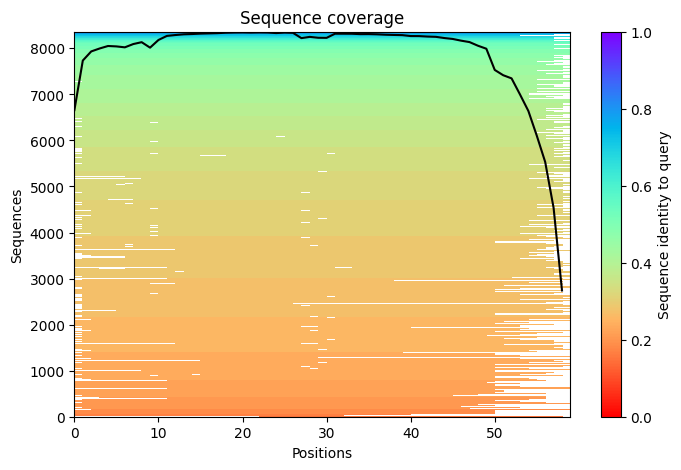

2024-11-01 16:12:06,513 Setting max_seq=512, max_extra_seq=5120
2024-11-01 16:12:29,264 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.6 pTM=0.755
2024-11-01 16:12:34,352 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.5 pTM=0.759 tol=0.288
2024-11-01 16:12:39,467 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.2 pTM=0.755 tol=0.0361
2024-11-01 16:12:44,600 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96 pTM=0.755 tol=0.0362
2024-11-01 16:12:44,602 alphafold2_ptm_model_1_seed_000 took 31.7s (3 recycles)
2024-11-01 16:12:44,622 reranking models by 'plddt' metric
2024-11-01 16:12:44,623 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=96 pTM=0.755
2024-11-01 16:12:45,326 Done


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

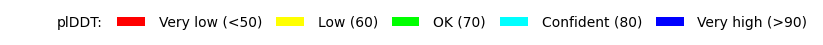

In [ ]:
#@title Run this cell to generate the sequence's 3D structure and structure stability prediction!
display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1
color = "lDDT"
show_sidechains = False
show_mainchains = False

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=1,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    input_features_callback=input_features_callback,
    stop_at_score=float(100),
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

# Generate PyMOL 3D structure


tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()